In [12]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
# State Data with fips state data for geolocation
State_url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
S_df = pd.read_csv(State_url)
print(S_df.head(5))

         date       state  fips  cases  deaths
0  2020-01-21  Washington    53      1       0
1  2020-01-22  Washington    53      1       0
2  2020-01-23  Washington    53      1       0
3  2020-01-24    Illinois    17      1       0
4  2020-01-24  Washington    53      1       0


In [14]:
df = S_df.loc[S_df['state'] == 'Ohio']
df

,date,state,fips,cases,deaths
442,2020-03-09,Ohio,39,3,0
480,2020-03-10,Ohio,39,3,0
524,2020-03-11,Ohio,39,4,0
571,2020-03-12,Ohio,39,5,0
621,2020-03-13,Ohio,39,13,0
672,2020-03-14,Ohio,39,26,0
725,2020-03-15,Ohio,39,37,0
778,2020-03-16,Ohio,39,50,0
831,2020-03-17,Ohio,39,67,0
885,2020-03-18,Ohio,39,90,0


In [15]:
df = df.loc[:,['date','cases','fips','deaths']]
FMT = '%Y-%m-%d'
date = df['date']
df['date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01", FMT)).days  )

In [16]:
df

,date,cases,fips,deaths
442,68,3,39,0
480,69,3,39,0
524,70,4,39,0
571,71,5,39,0
621,72,13,39,0
672,73,26,39,0
725,74,37,39,0
778,75,50,39,0
831,76,67,39,0
885,77,90,39,0


In [17]:
# Calculate the general percentage of infection by dividing the number of new cases
# by the average census and multiplying by 100.
# For more specific rates, divide the number of new cases by total resident days and multiply by 1000,
# which gives you the number of infections per 1000 resident days.

# Ohio 2020 pop. 11,750,000
ohio_pop = 11750000
Inf_rate = ((df.iloc[-1,1]/ohio_pop)*1000)
print(Inf_rate)
# print(df.cases[-1:]) # df.iloc[-1,1]
# print(df.date[-1:]) # df.iloc[-1,0]
current_cases = df.iloc[-1,1]
current_date = df.iloc[-1,0]
print("Current date delta: ",current_date,"Current cases: ",current_cases)
# print((3739/ohio_pop)*1000)

0.5620425531914893
Current date delta:  102 Current cases:  6604


In [18]:
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

In [19]:
a = Inf_rate
b = df.iloc[-1,0] # 94 # df.date[-1:] # Current date num
c = df.iloc[-1,1] # 3739 # df.cases[-1:] # Current case num
x = list(df.iloc[:,0]) # dates
y = list(df.iloc[:,1]) # cases
p0=[5,20,20000]
fit = curve_fit(logistic_model,x,y,p0)
fit

(array([4.68913711e+00, 9.44492071e+01, 7.72644506e+03]),
 array([[1.22414702e-02, 2.28517167e-02, 1.50355595e+01],
        [2.28517167e-02, 5.74893430e-02, 3.65627854e+01],
        [1.50355595e+01, 3.65627854e+01, 2.45540040e+04]]))

In [20]:
errors = [np.sqrt(fit[1][i][i]) for i in [0,1,2]]
print(errors)

[0.11064117788093097, 0.2397693538387284, 156.6971728003817]


In [21]:
sol = int(fsolve(lambda x : logistic_model(x,a,b,c) - int(c),b))

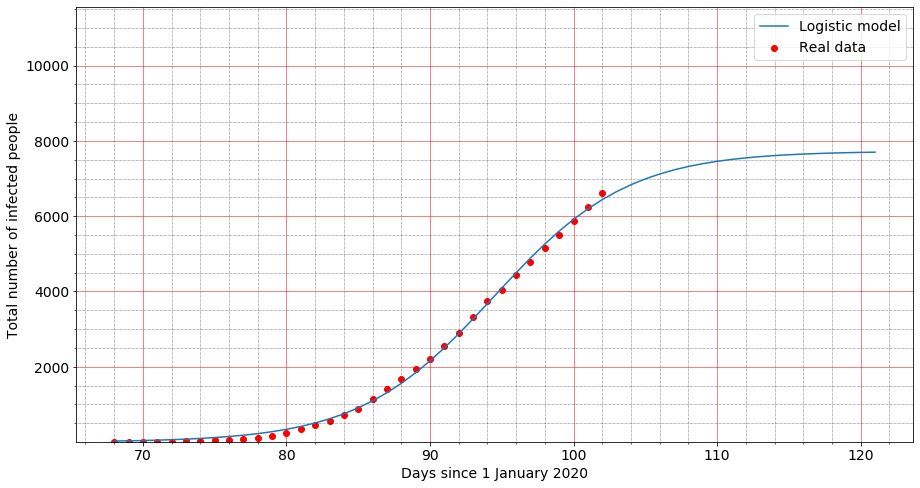

In [22]:
pred_x = list(range(max(x),sol))
plt.rcParams['figure.figsize'] = [15, 8]

plt.rc('font', size=14, )

# Real data
plt.scatter(x,y,label="Real data",color="red")

# Predicted logistic curve
plt.plot(x+pred_x, [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x+pred_x], label="Logistic model")

plt.legend()
plt.xlabel("Days since 1 January 2020")
plt.ylabel("Total number of infected people")
plt.ylim((min(y)*2.5,c*1.75))

# plt.grid()

# Turn on the minor TICKS, which are required for the minor GRID
plt.minorticks_on()

# Customize the major grid
plt.grid(which='major', linestyle='-', linewidth='0.5', color='red')
# Customize the minor grid
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')